In [1]:
%load_ext autoreload
%matplotlib inline

In [88]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import keras
#from keras.models import Sequential
from keras.layers import Input, concatenate
from keras.models import Model

import matplotlib.pyplot as plt

In [89]:
import numpy as np
from numpy import concatenate

In [90]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [91]:
%store -r ili_GLL

In [92]:
l = len(ili_GLL.columns)
print("The data contains {} features".format(l))
ili_GLL.head()

The data contains 8 features


,date,year,month,week,state,latitude,longitude,ili_activity_group
0,2010-10-09,2010,10,40,AK,61.370716,-152.404419,Minimal
1,2010-10-16,2010,10,41,AK,61.370716,-152.404419,Minimal
2,2010-10-23,2010,10,42,AK,61.370716,-152.404419,Minimal
3,2010-10-30,2010,10,43,AK,61.370716,-152.404419,Minimal
4,2010-11-06,2010,10,44,AK,61.370716,-152.404419,Minimal


In [239]:
#we put everything together
#sepate by states
datasets = {}
states_label = ili_GLL.state.unique()

In [240]:
for s in states_label:
    datasets[s] = ili_GLL[(ili_GLL.state == s)]
    datasets[s].drop(['date'], 1, inplace=True)
    datasets[s].drop(['state'], 1, inplace=True)

/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
nstates = len(datasets)
print("Number of location : {}".format(nstates))

In [265]:
i=0
for state in datasets:
    if len(datasets[state]) > 208:
        i+=1        
print i

310
237
299
310
310
216
310
283
240
310
310
310
215
304
308
307
300
296
305
310
310
225
289
310
292
260
240
288
308
310
305
261
214
276
310
264
284
37


In [258]:
nstates = len(datasets)
print("Number of location : {}".format(nstates))       
print(datasets.keys())

Number of location : 46
['WA', 'DE', 'WI', 'WV', 'HI', 'WY', 'NH', 'NM', 'TX', 'NC', 'ND', 'NE', 'TN', 'NY', 'PA', 'CA', 'NV', 'VA', 'CO', 'AK', 'AL', 'AR', 'VT', 'IL', 'GA', 'IN', 'IA', 'OK', 'AZ', 'ID', 'CT', 'ME', 'MD', 'MA', 'OH', 'UT', 'MO', 'MN', 'MI', 'KS', 'MT', 'MS', 'SC', 'KY', 'OR', 'SD']


In [282]:
# load dataset
dataset = datasets['NY']
print(dataset.count())
dataset.head()

year                  310
month                 310
week                  310
latitude              310
longitude             310
ili_activity_group    310
dtype: int64


,year,month,week,latitude,longitude,ili_activity_group
7480,2010,10,40,42.165726,-74.948051,Minimal
7481,2010,10,41,42.165726,-74.948051,Minimal
7482,2010,10,42,42.165726,-74.948051,Minimal
7483,2010,10,43,42.165726,-74.948051,Minimal
7484,2010,10,44,42.165726,-74.948051,Minimal


In [297]:
def create_model(datasets, timesteps = 1, features= 6, batch_size = 51, n_neurons = 50):
    #dataLength =  4 weeks  
    weeks = 52 * 4
    labels = datasets.keys()
    i = 0
    stateInputs = {}
    stateLayers = []
    for state in datasets:
        data = datasets[state]
        if (len(data) >= weeks):
            i+=1
            data = datasets[state]
            inputName = "{}_input".format(state)
            stateInputs[inputName] = Input(shape=(timesteps,features),
                                           batch_shape =(batch_size, timesteps, features), 
                                           name=inputName)
            stateL = LSTM(n_neurons, return_sequences=False, stateful=True,
                                batch_input_shape=(batch_size, timesteps, features))(stateInputs[inputName])
            stateLayers.append(stateL)
    
    print("number of states: {}".format(i))
    #combined the output
    output = keras.layers.concatenate(stateLayers)
    output = Dense(1, activation='relu', name='wheighthedAverage_output')(output)
    stateInput = stateInputs.values()
    
    model = Model(inputs = stateInput, outputs = [output])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [298]:
tX, tx, tY, ty  = list(), list(), list(), list()
weeks = 52 * 4
i = 0
for state in datasets:
    if (len(datasets[state])  > weeks):
        i+=1
        values =  data.head(weeks).values
        print(len(values))
        # integer encode direction
        encoder = LabelEncoder()
        values[:,5] = encoder.fit_transform(values[:,5])
        # ensure all data is float
        values = values.astype('float32')
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        # frame as supervised learning
        reframed = series_to_supervised(scaled)
        # drop columns we don't want to predict
        reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
        #print(reframed.head())
        # split into train and test sets
        values = reframed.values
        n_train_weeks = 52 * 3
        train = values[:n_train_weeks, :]
        print train.shape
        test = values[n_train_weeks:, :]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        tX.append(train_X)
        tx.append(test_X)
        tY.append(train_y)
        ty.append(test_y)
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("number of states: {}".format(i))

208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (156,), (51, 1, 6), (51,))
208
(156, 7)
((156, 1, 6), (

In [299]:
model = create_model(datasets)

number of states: 37


In [303]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
WA_input (InputLayer)           (51, 1, 6)           0                                            
__________________________________________________________________________________________________
DE_input (InputLayer)           (51, 1, 6)           0                                            
__________________________________________________________________________________________________
WI_input (InputLayer)           (51, 1, 6)           0                                            
__________________________________________________________________________________________________
WV_input (InputLayer)           (51, 1, 6)           0                                            
__________________________________________________________________________________________________
HI_input (

In [307]:
# fit network
history = model.fit(tX, 
                    tY[0], 
                    epochs=10, 
                    batch_size=51, 
                    validation_data=(tx, ty[0]),
                    verbose=2, 
                    shuffle=False)

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 156 samples

In [306]:
values = dataset.values
values

array([[2010, 10, 40, 42.165726, -74.948051, 'Minimal'],
       [2010, 10, 41, 42.165726, -74.948051, 'Minimal'],
       [2010, 10, 42, 42.165726, -74.948051, 'Minimal'],
       ..., 
       [2015, 9, 37, 42.165726, -74.948051, 'Minimal'],
       [2015, 9, 38, 42.165726, -74.948051, 'Minimal'],
       [2015, 9, 39, 42.165726, -74.948051, 'Insufficient Data']], dtype=object)

In [70]:
# integer encode direction
encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])
# ensure all data is float
values = values.astype('float32')

In [284]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var5(t)  \
1        0.0   0.818182   0.764706        0.0        0.0   0.666667      0.0   
2        0.0   0.818182   0.784314        0.0        0.0   0.666667      0.0   
3        0.0   0.818182   0.803922        0.0        0.0   0.666667      0.0   
4        0.0   0.818182   0.823529        0.0        0.0   0.666667      0.0   
5        0.0   0.818182   0.843137        0.0        0.0   0.666667      0.0   

    var6(t)   var7(t)  
1  0.666667  0.666667  
2  0.666667  0.666667  
3  0.666667  0.666667  
4  0.666667  0.666667  
5  0.666667  0.666667  


In [72]:
# split into train and test sets
values = reframed.values
n_train_weeks = 52 * 3
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((156, 1, 6), (156,), (153, 1, 6), (153,))


In [73]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [74]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

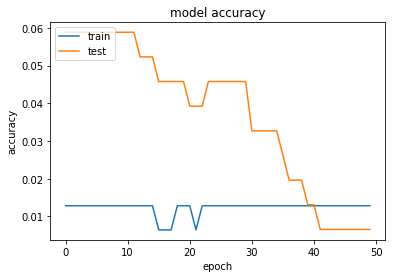

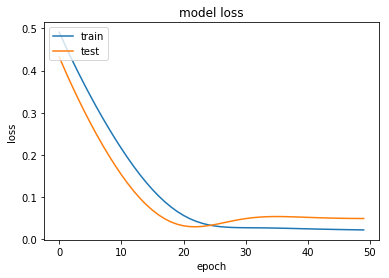

In [243]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [77]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.107
